
## DQN


In [6]:

## !pip install torch
## !pip install matplotlib


In [7]:

import gym
import numpy as np
import random

import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [8]:

stepsList        = []
rewardsList      = []
success_list     = [0.0005]


In [9]:

learning_rate = 0.001       ## Adam default learning rate
y             = 0.99
num_episodes  = 4000

epsilon       = 0.1       ## 0.2    , 0.01


In [10]:

def gen_state_vector(s):
    
    states_np = np.identity(16)[s:s+1]
    
    
    states_np = states_np.astype(   np.float32  )
    ## print(states_np.dtype )
    inputs1 = torch.from_numpy( states_np )
    return inputs1


In [13]:

s = 12

gen_state_vector(s)


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])

In [14]:

class Q_NN_Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.linear1    = nn.Linear(16, 4)
        self.act1       = nn.Softmax(dim=1)

    def forward(self, s):
        
        x          = gen_state_vector(s)
        
        x          = self.linear1( x )
        Qout       = self.act1( x )
        
        Qout       = torch.squeeze(Qout, 0)

        return Qout


In [16]:

class Q_NN_MLP_Net(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        self.linear1    = nn.Linear(16, 10)
        self.act1       = nn.ReLU()          ## Tanh()              ## nn.Sigmoid()
        self.linear2    = nn.Linear(10, 4)
        self.act2       = nn.Softmax(dim=1)

    def forward(self, s):
        
        x    = gen_state_vector(s)
        
        x    = self.linear1( x )
        x    = self.act1(    x )
        x    = self.linear2( x )
        Qout = self.act2(    x )
        
        Qout = torch.squeeze(Qout, 0)
        
        return Qout
    


In [17]:

env = gym.make('FrozenLake-v1')


In [18]:

## model = Q_NN_Net()

model = Q_NN_MLP_Net()


opt = torch.optim.Adam( model.parameters(), lr=learning_rate )



## Main Loop


In [19]:

epsilon_delta = -(epsilon / num_episodes)


for i in range(num_episodes):
    
    s = env.reset()
    s    = s[0]  ## env returns tuple so select first of tuple
    rAll = 0  
    d    = False 
    j = 0
    
    if i % 200 == 0:
         print("Game ", i, " of ", num_episodes)
    
    while j < 1000:
        
        if (np.random.rand(1) < epsilon): 
            a = env.action_space.sample()
        else:
            Q_s          = model(  s  ).detach()
            _, max_index = torch.max(Q_s, 0) 
            a            = max_index.item()
    
                     
        s1, r, d, _, _ = env.step(a)
              
        if d == True and r == 0: 
             r = -1
        
        
        ############################################
        Q_s1      = model(  s1 ).detach()     # detach from graph
        maxQ_s1   = torch.max( Q_s1 )  
        target_q  = r + 0.99 * maxQ_s1
        
        ############################################
        q_pred = model(  s  )[a]   
      
        ############################################
        ## loss = loss_fn(  q_pred, target_q )
        loss = F.smooth_l1_loss( q_pred, target_q )
                
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        rAll = rAll + r
        j = j + 1
      
        s = s1
        if d == True: 
            break
                    
    epsilon = epsilon + epsilon_delta
            
    if d == True and r > 0:
        success_list.append(1)     
        stepsList.append(j)          ##  steps taken per game
    else:
        success_list.append(0)
                
           
    ## stepsList.append(j)           ##  steps taken per game
    rewardsList.append(rAll)         ## reward total per game
    
    


Game  0  of  4000
Game  200  of  4000
Game  400  of  4000
Game  600  of  4000
Game  800  of  4000
Game  1000  of  4000
Game  1200  of  4000
Game  1400  of  4000
Game  1600  of  4000
Game  1800  of  4000
Game  2000  of  4000
Game  2200  of  4000
Game  2400  of  4000
Game  2600  of  4000
Game  2800  of  4000
Game  3000  of  4000
Game  3200  of  4000
Game  3400  of  4000
Game  3600  of  4000
Game  3800  of  4000


In [20]:

print("last 100 epochs of success: " + str(sum(success_list[-100:])) + "%")


last 100 epochs of success: 68%


[-0.88, -0.66, -0.7, -0.84, -0.22, -0.36, -0.34, -0.34, -0.36, -0.3, -0.28, -0.36, -0.06, -0.18, -0.2, -0.28, -0.36, -0.12, -0.22, -0.08, -0.16, -0.14, -0.08, 0.16, -0.02, 0.0, -0.06, 0.12, 0.12, 0.24, 0.24, 0.1, 0.3, 0.32, 0.28, 0.42, 0.26, 0.58, 0.42, 0.36]
{-0.88, -0.66, -0.7, -0.84, -0.36, -0.34, -0.3, -0.28, -0.06, -0.12, 0.0, 0.42, 0.26, -0.08, -0.02, -0.14, 0.36, 0.28, 0.12, -0.22, -0.16, 0.16, 0.1, -0.2, 0.3, -0.18, 0.32, 0.24, 0.58}
40
-3.6799999999999993
4000


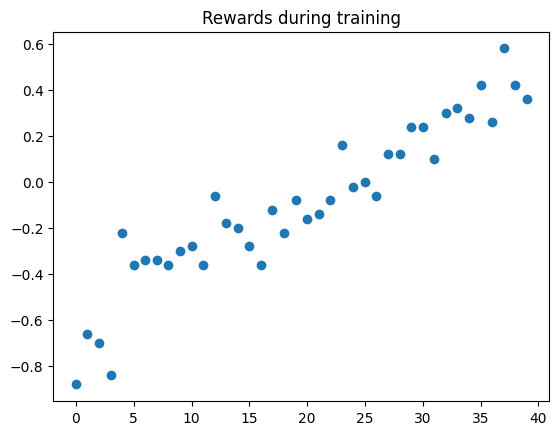

In [21]:

## rewardsList = rewardsList[-20:]

step_size = 100

## new_avg_per_n_entries
r_rc = [  sum(rewardsList[i:i+step_size])/step_size for i in range(0, len(rewardsList), step_size )  ]

rewardsList = r_rc 

print(rewardsList)
print(set(rewardsList))
print(len(rewardsList))
print(sum(rewardsList))
print( num_episodes )


ind_rew = [i for i in range(len(rewardsList))]
plt.scatter(ind_rew, rewardsList)
## plt.plot(rewardsList)
plt.title("Rewards during training")
plt.show()


In [22]:

stepsList    = [0.0005]
success_list = [0.0005]


test_games = 100

for i in range(test_games):
    s = env.reset()
    s = s[0]
    j = 0
    while j < 1000:
                    
        agent_out = model(s).detach()
        _, max_index = torch.max(agent_out, 0)   
        a = max_index.data.cpu().numpy()[()]


        s1, r, d, _, _ = env.step(a)
        if d == True and r == 0: 
            r = -1
                
        s = s1
        j = j + 1
            
        if d == True: 
            break
            
    if d == True and r > 0:
        success_list.append(1)
    else:
        success_list.append(0)
    stepsList.append(j)
    


In [23]:

print(set(success_list))
print(len(success_list))
print(sum(success_list))
print("Percent of won games(test): " , str( sum(success_list)/ len(success_list) ) )


{0, 1, 0.0005}
101
71.0005
Percent of won games(test):  0.7029752475247525
